In [50]:
import torch
import torch.nn as nn
from torch.nn.functional import *
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math
import matplotlib.animation as animation
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from torch.autograd.functional import jacobian
from torch.func import vmap
import functorch

# Example 1: Poisson System with a Cubic Hamiltonian

In [ ]:
def Ham(y):
    '''
    Example 1: Cubic Hamiltonian Defined on the product of 2 Spheres
    '''
    distances = torch.norm(transform(y),p=3)
    return distances

In [91]:
def sampling(M):
    #Sample Uniform Distribution on the product of 2 spheres
    u = torch.rand(M,4)
    u[:,0] = torch.arccos(2*u[:,0]-1)
    u[:,2] = torch.arccos(2*u[:,2]-1)
    u[:,1] = 2*torch.pi*u[:,1]
    u[:,3] = 2*torch.pi*u[:,3]
    return u

def Ham_Vec_Field(data, sigma):
    #Compute the Hamiltonian Vector Field of a Given Hamiltonian 
    n,d = data.shape
    H = 0
    for i in range(n):
        H += Ham(data[i])
    H.backward()
    res = -1*B_tensor_data(data)@(data.grad.flatten())
    return res + torch.normal(0, sigma, size=res.size())

def g_metric(y):
    #This function computes the Riemannian Metric in the paper
    return torch.stack((torch.tensor([1,0,0,0]), torch.tensor([0,torch.sin(y[0])**2,0,0]), torch.tensor([0,0,1,0]), torch.tensor([0,0,0,torch.sin(y[2])**2])))

def B_tensor(y):
    #This function computes the Poisson Tensor in the paper
    return -1*torch.tensor([[0,lambda1*torch.sin(y[0]),0,0],[-1*lambda1*torch.sin(y[0]),0,0,0], [0,0,0,lambda2*torch.sin(y[2])],[0,0,-1*lambda2*torch.sin(y[2]),0]])

def J_structure(y):
    #This function computes the so-called Compatible Structure in the paper
    return -1*B_tensor(y)@g_metric(y)

def g_metric_data(data):
    n,d = data.shape
    temp = torch.zeros(n*d,n*d)
    for i in range(n):
        temp[i*d:(i+1)*d,i*d:(i+1)*d] = g_metric(data[i])
    return temp

def B_tensor_data(data):
    n,d = data.shape
    temp = torch.zeros(n*d,n*d)
    for i in range(n):
        temp[i*d:(i+1)*d,i*d:(i+1)*d] = B_tensor(data[i])
    return temp

def J_structure_data(data):
    n,d = data.shape
    temp = torch.zeros(n*d,n*d)
    for i in range(n):
        temp[i*d:(i+1)*d,i*d:(i+1)*d] = J_structure(data[i])
    return temp

def transform(y):
    #This function parameterizes the product of 2 spheres as a submanifold of R^6
    return torch.stack(([torch.sin(y[0])*torch.cos(y[1]), torch.sin(y[0])*torch.sin(y[1]), torch.cos(y[0]), torch.sin(y[2])*torch.cos(y[3]), torch.sin(y[2])*torch.sin(y[3]), torch.cos(y[2])]))

def transform_data(data):
    return torch.vmap(transform)(data)

def Jacobian(y):
    #This function computes the Jacobian matrix of the above parameterization
    return jacobian(transform, y)

def Jacobian_data(data):
    return functorch.vmap(functorch.jacrev(transform))(data)

In [ ]:
def G_N(data, rho):
    #This function computes the Differential Gram matrix on the Tangent Spaces as defined in the paper
    n,d = data.shape
    temp_trans = torch.zeros(n,n,d,d+2)
    jacob_trans = Jacobian_data(data).transpose(1,2)
    for i in range(n):
        temp_trans[i,i,:,:] = jacob_trans[i,:,:] 
    temp = torch.zeros(n,n,d+2,d)
    jacob = Jacobian_data(data)
    for i in range(n):
        temp[i,i,:,:] = jacob[i,:,:] 
    temp = temp.permute(0,2,1,3).reshape(n*(d+2),n*d)
    temp_trans = temp_trans.permute(0,2,1,3).reshape(n*d,n*(d+2))
    return B_tensor_data(data)@(temp_trans@K_1_2(transform_data(data),rho)@temp)@B_tensor_data(data).T@g_metric_data(data)


def coefficients_c(data, vec_field, lamda, rho):
    #This function computes the coefficient c of the Differential Representer's Theorem in the paper
    n,d = data.size()
    return torch.linalg.inv(G_N(data, rho)+lamda*n*torch.eye(n*d))@vec_field

def prediction(x, rho):
    #This function computes the predicted Hamiltonian function based on observed data
    n,d = data.shape
    return torch.inner(c_hat, -1*g_metric_data(data)@B_tensor_data(data)@((Jacobian_data(data).transpose(2,1))@(K_1_Gram_single(transform_data(data), transform(x), rho).reshape(n,-1,1))).reshape(-1))

def K(x, y, rho):
    # Compute pairwise value of RBF/Gaussian kernel
    distances = torch.cdist(x, y, p=2)
    kernel_matrix = torch.exp(-distances**2 / (rho **2))
    return kernel_matrix

def K_1_2(train_data, rho):
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = train_data.view(1,n,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,n,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,n))
    scalar = Gram(train_data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,n),(1,2,0)).view(n,n,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def Gram(data, rho):
    #This function computes the Usual Gram matrix of a Kernel
    num_points = data.size(0)

    # Reshape data to (N, 1, D) and (1, N, D) to allow broadcasting
    data_i = data.view(num_points, 1, -1)
    data_j = data.view(1, num_points, -1)

    # Compute the Gram matrix using vectorized operations
    gram_matrix = K(data_i, data_j, rho).view(num_points, num_points)

    return gram_matrix

def Gram_single(train_data, data, rho):
    num_points = train_data.size(0)
    data_i = train_data.view(num_points,1,-1)
    data_j = data.view(1,1,-1)
    gram_matrix = K(data_i, data_j, rho).view(num_points, 1)
    return gram_matrix

def K_1_Gram_single(train_data, data, rho):
    return ((-2.0/rho**2)*Gram_single(train_data, data, rho)*(train_data-data)).flatten()

def K_1_2_Gram_single(train_data, data, rho):
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = data.view(1,1,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,1,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,1))
    scalar = Gram_single(train_data, data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,1),(1,2,0)).view(n,1,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def Prediction_Ham_Vec_Field(data, y, c_hat, rho):
    n, d = data.shape
    return B_tensor(y)@(((Jacobian_data(data).transpose(1,2)@K_1_2_Gram_single(transform_data(data), transform(y),rho).reshape(n,6,6)@Jacobian(y))).reshape(n*4,4).T)@J_structure_data(data)@c_hat

def get_train_error(train_data, train_vec_field, lamda, c_hat, rho):
    n, d = train_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, train_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    train_vec_field = train_vec_field.resize(n,d)
    error = torch.mean(torch.norm(train_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat)
    return error

def get_test_error(train_data, test_data, test_vec_field, lamda, c_hat, rho):
    n, d = test_data.size()
    pred_Ham_vec_field = torch.zeros(n*d)

    for i in range(n):
        temp = Prediction_Ham_Vec_Field(train_data, test_data[i], c_hat, rho)
        pred_Ham_vec_field[i*d:(i+1)*d] = temp
    pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
    test_vec_field = test_vec_field.resize(n,d)
    print(torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1)), lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat))
    error = torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat)
    return error

def run_optimized_cross_validation(M_list, rho_list, c_list, cv):
    for M in M_list:
        sigma = 0
        lim = 1
        train_data = []
        np.random.seed(1)
        torch.manual_seed(1)
        train_data = sampling(M)
        train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
        n, d = train_data.size()
        train_vec_field = Ham_Vec_Field(train_data, sigma)
        error_list = []
        for rho in rho_list:
            for c in c_list:
                lamda = c*M**(-0.4)
                #Generating Training Data
                temp_error = 0
                for k in range(cv):
                    temp_train_data = torch.cat((train_data[:k*(n//cv)], train_data[(k+1)*(n//cv):]))
                    temp_train_vec_field = torch.cat((train_vec_field[:k*d*(n//cv)], train_vec_field[(k+1)*d*(n//cv):]))
                    temp_test_data = train_data[k*(n//cv):(k+1)*(n//cv)]
                    temp_test_vec_field = train_vec_field[k*d*(n//cv):(k+1)*d*(n//cv)]
                    #Training Phase
                    c_hat = coefficients_c(temp_train_data, temp_train_vec_field, lamda, rho)
                    temp_error += get_test_error(temp_train_data, temp_test_data, temp_test_vec_field, lamda, c_hat, rho).detach().numpy().item()
                print("rho:", rho, "c:", c, "error:", temp_error/cv)
                error_list.append((temp_error/cv, (rho,c)))
        error, best_params = min(error_list, key = lambda x: x[0])
        print("Number of Samples:", M, "Optimal rho:", best_params[0], "Optimal c:", best_params[1], "Error:", error)

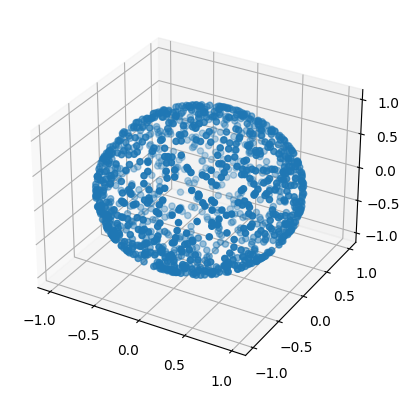

In [101]:
lambda1, lambda2 = 1, 1
M=1200
rho = 0.9
sigma = 0
lamda =0.0001*M**(-0.4)
np.random.seed(0)
torch.manual_seed(0)

data = sampling(M)
xyz_data = torch.vmap(transform)(data)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = xyz_data[:,0]
sequence_containing_y_vals = xyz_data[:,1]
sequence_containing_z_vals = xyz_data[:,2]

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
plt.show()

In [102]:
data = torch.tensor(data, dtype = torch.float32, requires_grad = True)
vec_field = Ham_Vec_Field(data, sigma)
c_hat = coefficients_c(data, vec_field, lamda, rho)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_67465/3914599239.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype = torch.float32, requires_grad = True)


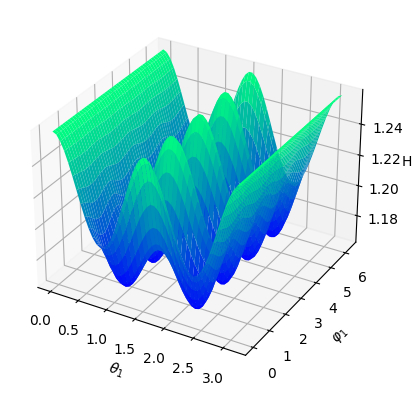

In [56]:
#Plot Ground Truth Hamiltonian
x = np.linspace(0, np.pi, 50)
y = np.linspace(0,2*np.pi,50)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        Z1[i,j] = Ham(torch.Tensor([X[i][j],Y[i][j],np.pi/2,0]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
plt.savefig("Groundtruth_Sphere_Norm.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

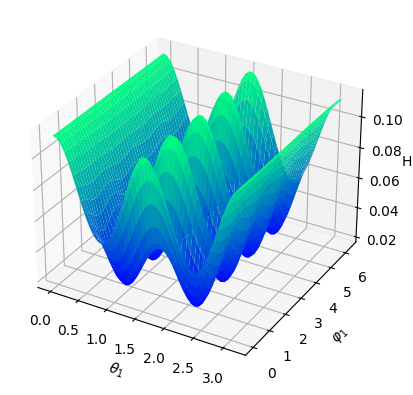

In [16]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(0, np.pi, 50)
y = np.linspace(0,2*np.pi,50)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        Z2[i,j] = prediction(torch.tensor([X[i][j],Y[i][j],np.pi/2,0], dtype=torch.float32), rho).detach()
Z2 = Z2.numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
plt.savefig("Learned_Sphere_Norm.png", bbox_inches='tight')
plt.show()

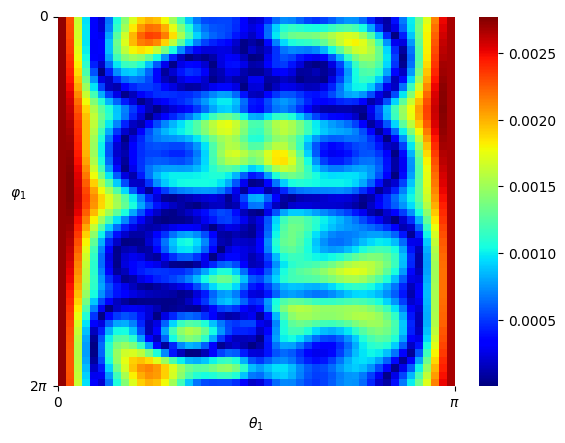

In [17]:
#Uniform on the sphere
#Plot Ground Truth Hamiltonian
grid = 50
x = np.linspace(0, np.pi, grid)
y = np.linspace(0, np.pi*2, grid)

distance = torch.mean((Z1-Z2))
Ham_abs_error = torch.abs(Z1-Z2-distance).detach().numpy()

ax = sns.heatmap(Ham_abs_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,2))
ax.set_xticklabels([r'0', r'$\pi$'])
ax.set_yticks(np.linspace(0,grid,2))
ax.set_yticklabels([r'0', r'$2\pi$'])
plt.xticks(rotation=0)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\varphi_1$', rotation=0)
plt.savefig("Absolute_Error_Sphere_Norm.png", bbox_inches='tight')
plt.show()

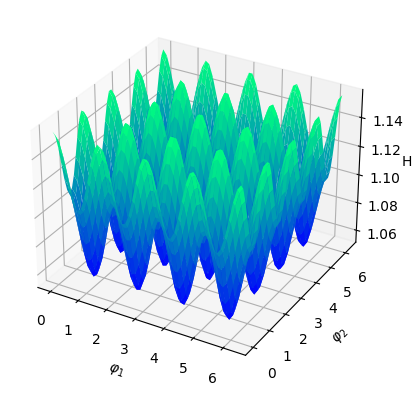

In [18]:
#Plot Ground Truth Hamiltonian
x = np.linspace(0,2*np.pi, 50)
y = np.linspace(0,2*np.pi,50)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        Z1[i,j] = Ham(torch.Tensor([np.pi/3,X[i][j],np.pi/3,Y[i][j]]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\varphi_1$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
plt.savefig("Groundtruth_Sphere_Norm_2.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

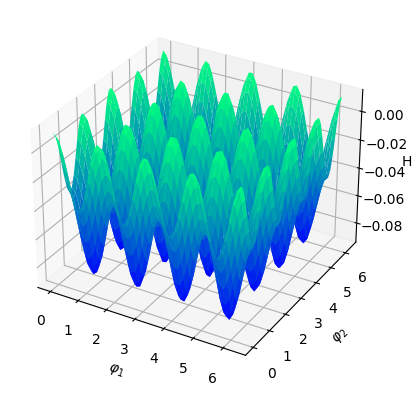

In [20]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(0,2*np.pi, 50)
y = np.linspace(0,2*np.pi,50)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        Z2[i,j] = prediction(torch.tensor([np.pi/3,X[i][j],np.pi/3,Y[i][j]], dtype=torch.float32), rho).detach()
Z2 = Z2.numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\varphi_1$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
plt.savefig("Learned_Sphere_Norm_2.png", bbox_inches='tight')
plt.show()

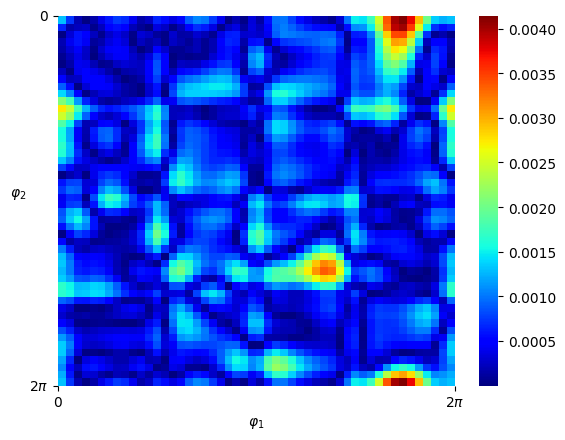

In [21]:
#Uniform on the sphere
#Plot Ground Truth Hamiltonian
grid = 50
x = np.linspace(0, np.pi*2, grid)
y = np.linspace(0, np.pi*2, grid)

distance = torch.mean((Z1-Z2))
Ham_abs_error = torch.abs(Z1-Z2-distance).detach().numpy()

ax = sns.heatmap(Ham_abs_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,2))
ax.set_xticklabels([r'0', r'$2\pi$'])
ax.set_yticks(np.linspace(0,grid,2))
ax.set_yticklabels([r'0', r'$2\pi$'])
plt.xticks(rotation=0)
plt.xlabel(r'$\varphi_1$')
plt.ylabel(r'$\varphi_2$', rotation=0)
plt.savefig("Absolute_Error_Sphere_Norm_2.png", bbox_inches='tight')
plt.show()

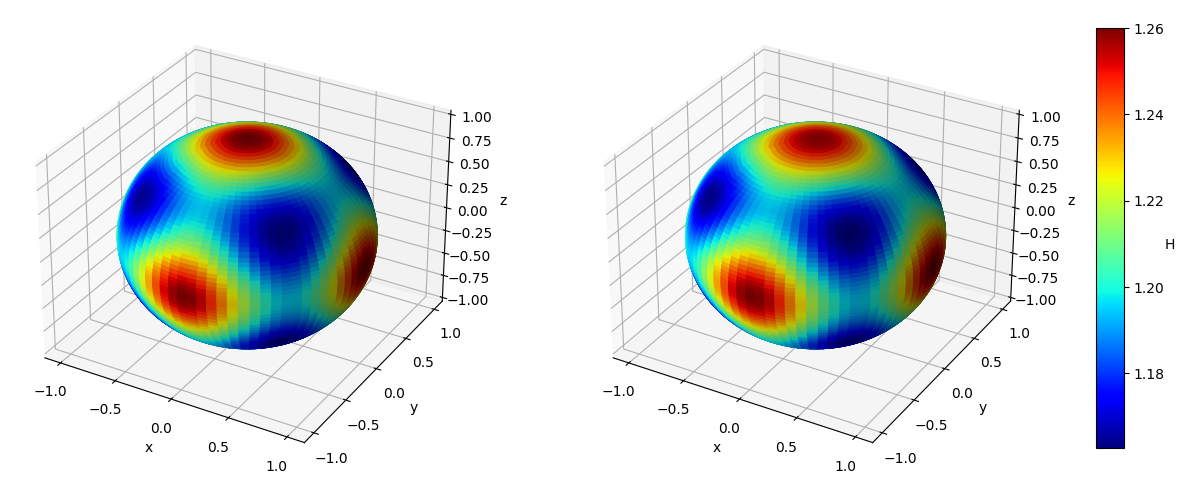

In [103]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

# Create the figure and the 3D axes

u = np.linspace(0, 2 * np.pi, 80)
v = np.linspace(0, np.pi, 80)

# Create the sphere surface
XX = 1 * np.outer(np.cos(u), np.sin(v))
YY = 1 * np.outer(np.sin(u), np.sin(v))
ZZ = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

# Create a random scalar field (unknown scale)

WW1 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW1[i][j] = Ham(torch.tensor([v[j],u[i],np.pi/2,0])).detach().numpy()
        
WW2 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW2[i][j] = prediction(torch.tensor([v[j],u[i],np.pi/2,0], dtype=torch.float32), rho).detach()


distance = np.mean((WW1-WW2))
WW2 = WW2+distance

# Get the min and max of the data for dynamic scaling
# Find the combined min and max to create a common color scale
combined_min = min(WW1.min(), WW2.min())
combined_max = max(WW1.max(), WW2.max())

# Normalize with the combined min and max
norm = Normalize(vmin=combined_min, vmax=combined_max)

fig = plt.figure(figsize=(14, 6))

# Plot WW1 on the left subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW1)), rstride=1, cstride=1)
ax1.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax1.yaxis.set_major_locator(MaxNLocator(5)) 
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Plot WW2 on the right subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW2)), rstride=1, cstride=1)
ax2.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax2.yaxis.set_major_locator(MaxNLocator(5)) 
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')


# Add color bar with precise positioning
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), cax=cbar_ax)
cbar.set_label('H', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.savefig("GroundTruth_and_Learned_Sphere_ColorPlot.png", bbox_inches='tight')
plt.show()


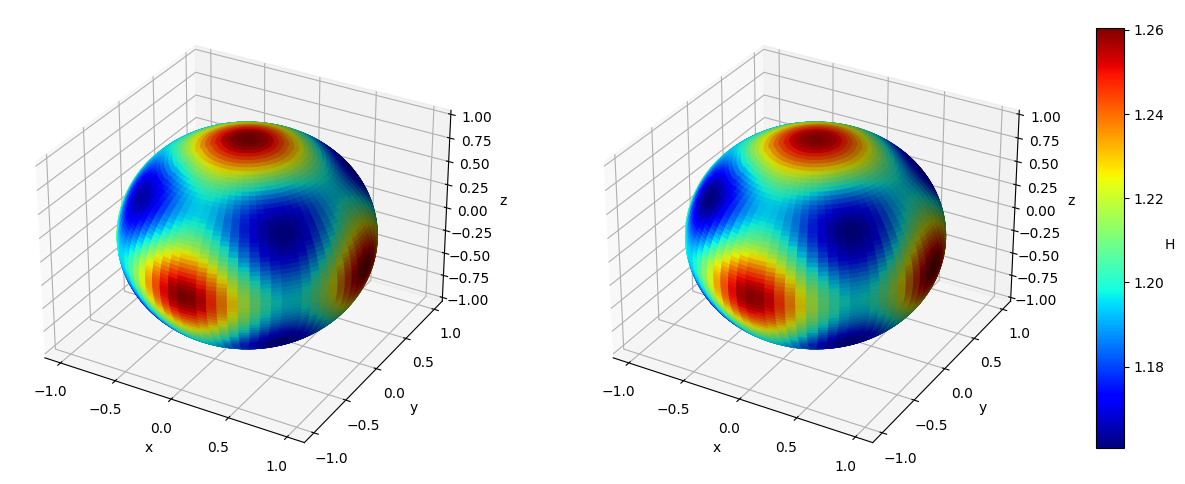

In [104]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

# Create the figure and the 3D axes

u = np.linspace(0, 2 * np.pi, 80)
v = np.linspace(0, np.pi, 80)

# Create the sphere surface
XX = 1 * np.outer(np.cos(u), np.sin(v))
YY = 1 * np.outer(np.sin(u), np.sin(v))
ZZ = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

# Create a random scalar field (unknown scale)

WW1 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW1[i][j] = Ham(torch.tensor([np.pi/2,0,v[j],u[i]])).detach().numpy()
        
WW2 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW2[i][j] = prediction(torch.tensor([np.pi/2,0,v[j],u[i]], dtype=torch.float32), rho).detach()


distance = np.mean((WW1-WW2))
WW2 = WW2+distance

# Get the min and max of the data for dynamic scaling
# Find the combined min and max to create a common color scale
combined_min = min(WW1.min(), WW2.min())
combined_max = max(WW1.max(), WW2.max())

# Normalize with the combined min and max
norm = Normalize(vmin=combined_min, vmax=combined_max)

fig = plt.figure(figsize=(14, 6))

# Plot WW1 on the left subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW1)), rstride=1, cstride=1)
ax1.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax1.yaxis.set_major_locator(MaxNLocator(5)) 
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Plot WW2 on the right subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW2)), rstride=1, cstride=1)
ax2.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax2.yaxis.set_major_locator(MaxNLocator(5)) 
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')


# Add color bar with precise positioning
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), cax=cbar_ax)
cbar.set_label('H', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.savefig("GroundTruth_and_Learned_Sphere_ColorPlot_2.png", bbox_inches='tight')
plt.show()


# Example 2: Two Vetex-System 

In [105]:
lambda1, lambda2 = 1,1
def Ham(y):
    '''
    Example 2: The Two-Vertex System on the product of 2 Spheres
    '''
    return -1*lambda1*lambda2*torch.log(1-torch.sin(y[0])*torch.sin(y[2])*torch.cos(y[1]-y[3])-torch.cos(y[0])*torch.cos(y[2]))

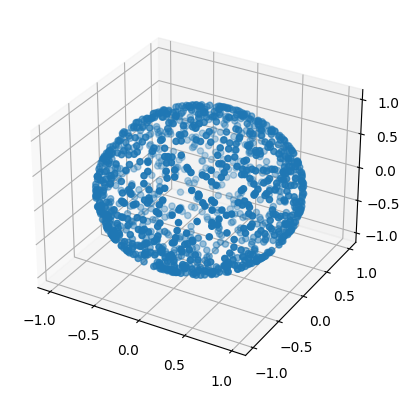

In [108]:
lambda1, lambda2 = 1, 1
M=1200
rho = 0.7
sigma = 0
# lamda =0.001*M**(-0.4)
lamda =0.01*M**(-0.4)
np.random.seed(0)
torch.manual_seed(0)

data = sampling(M)
xyz_data = torch.vmap(transform)(data)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = xyz_data[:,0]
sequence_containing_y_vals = xyz_data[:,1]
sequence_containing_z_vals = xyz_data[:,2]

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
plt.show()

In [109]:
data = torch.tensor(data, dtype = torch.float32, requires_grad = True)
vec_field = Ham_Vec_Field(data, sigma)
c_hat = coefficients_c(data, vec_field, lamda, rho)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_67465/3914599239.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype = torch.float32, requires_grad = True)


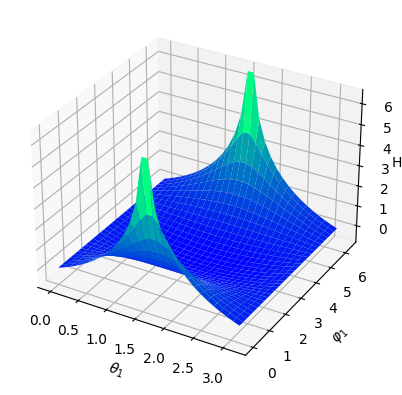

In [110]:
#Plot Ground Truth Hamiltonian
x = np.linspace(0, np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z1[i,j] = Ham(torch.Tensor([X[i][j],Y[i][j],np.pi/2,0]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Groundtruth_Typhoon.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

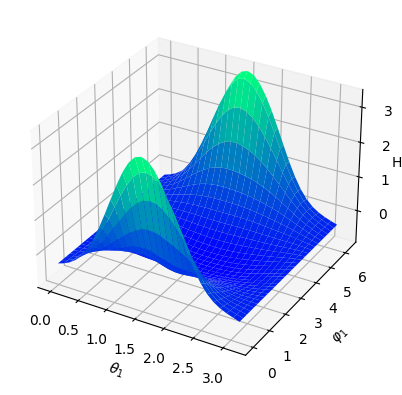

In [8]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(0, np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z2[i,j] = prediction(torch.tensor([X[i][j],Y[i][j],np.pi/2,0], dtype=torch.float32), rho)
Z2 = Z2.detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Learned_Typhoon.png", bbox_inches='tight')
plt.show()

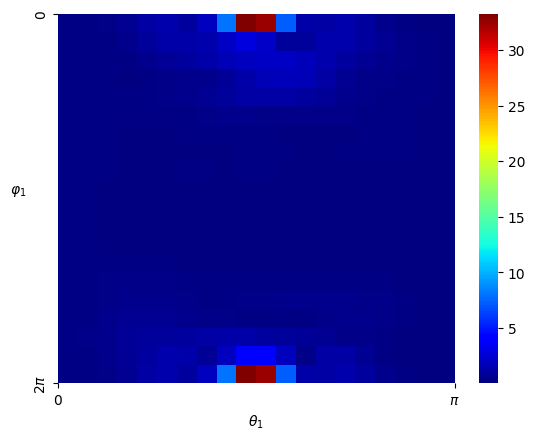

In [10]:
#Plot Hamiltonian Vector Field Error
grid = 20
x = np.linspace(0,np.pi, grid)
y = np.linspace(0,2*np.pi, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        U = Ham_Vec_Field(torch.tensor([[X[i][j],Y[i][j],np.pi/2,0]], dtype=torch.float32, requires_grad = True),0)
        V = Prediction_Ham_Vec_Field(data, torch.tensor([X[i][j],Y[i][j],np.pi/2,0], dtype=torch.float32), c_hat, rho)
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.detach().numpy()

ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,2))
ax.set_xticklabels([r'0', r'$\pi$'])
ax.set_yticks(np.linspace(0,grid,2))
ax.set_yticklabels([r'0', r'$2\pi$'])
plt.xticks(rotation=0)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\varphi_1$', rotation=0)
plt.savefig("Vector_Field_Error_Typhoon.png", bbox_inches='tight')
plt.show()

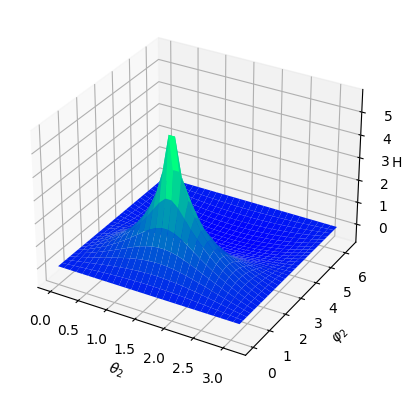

In [8]:
#Plot Ground Truth Hamiltonian
x = np.linspace(0, np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z1[i,j] = Ham(torch.Tensor([np.pi/2,np.pi/2,X[i][j],Y[i][j]]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Groundtruth_Typhoon_2.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

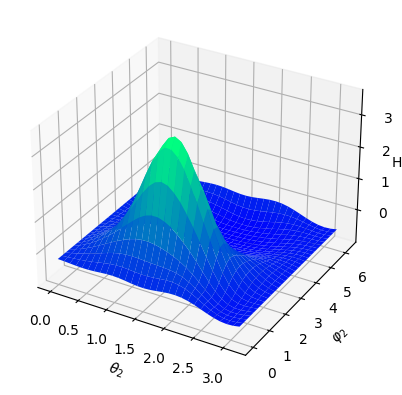

In [9]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(0, np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z2[i,j] = prediction(torch.tensor([np.pi/2,np.pi/2,X[i][j],Y[i][j]], dtype=torch.float32), rho)
Z2 = Z2.detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_2$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Learned_Typhoon_2.png", bbox_inches='tight')
plt.show()

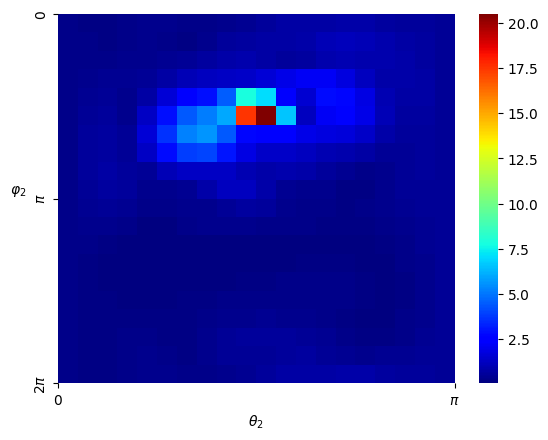

In [11]:
#Plot Hamiltonian Vector Field Error
grid = 20
x = np.linspace(0,np.pi, grid)
y = np.linspace(0,2*np.pi, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        U = Ham_Vec_Field(torch.tensor([[np.pi/2,np.pi/2,X[i][j],Y[i][j]]], dtype=torch.float32, requires_grad = True),0)
        V = Prediction_Ham_Vec_Field(data, torch.tensor([np.pi/2,np.pi/2,X[i][j],Y[i][j]], dtype=torch.float32), c_hat, rho)
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.detach().numpy()

ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,2))
ax.set_xticklabels([r'0', r'$\pi$'])
ax.set_yticks(np.linspace(0,grid,3))
ax.set_yticklabels([r'0', r'$\pi$', r'$2\pi$'])
plt.xticks(rotation=0)
plt.xlabel(r'$\theta_2$')
plt.ylabel(r'$\varphi_2$', rotation=0)
plt.savefig("Vector_Field_Error_Typhoon_2.png", bbox_inches='tight')
plt.show()

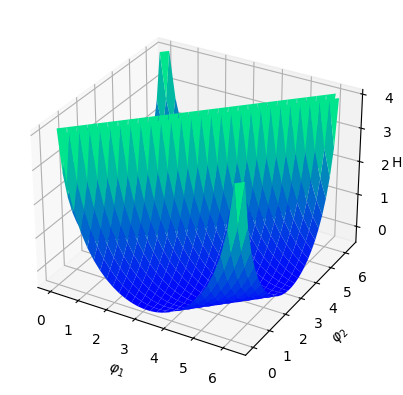

In [11]:
#Plot Ground Truth Hamiltonian
x = np.linspace(0,2*np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z1[i,j] = Ham(torch.Tensor([np.pi/3,X[i][j],np.pi/3,Y[i][j]]))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\varphi_1$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Groundtruth_Typhoon_3.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

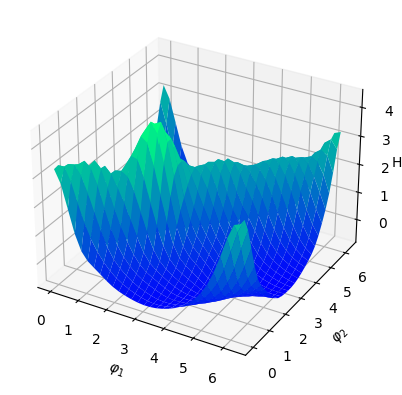

In [12]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(0, 2*np.pi, 30)
y = np.linspace(0,2*np.pi,30)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((30,30))
for i in range(30):
    for j in range(30):
        Z2[i,j] = prediction(torch.tensor([np.pi/3,X[i][j],np.pi/3,Y[i][j]], dtype=torch.float32), rho)
Z2 = Z2.detach().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\varphi_1$')
ax.set_ylabel(r'$\varphi_2$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=-4.5
plt.savefig("Learned_Typhoon_3.png", bbox_inches='tight')
plt.show()

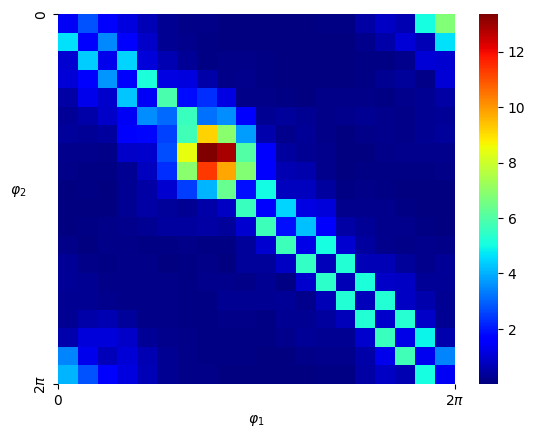

In [14]:
#Plot Hamiltonian Vector Field Error
grid = 20
x = np.linspace(0,2*np.pi, grid)
y = np.linspace(0,2*np.pi, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        U = Ham_Vec_Field(torch.tensor([[np.pi/3,X[i][j],np.pi/3,Y[i][j]]], dtype=torch.float32, requires_grad = True),0)
        V = Prediction_Ham_Vec_Field(data, torch.tensor([np.pi/3,X[i][j],np.pi/3,Y[i][j]], dtype=torch.float32), c_hat, rho)
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.detach().numpy()

ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,2))
ax.set_xticklabels([r'0', r'$2\pi$'])
ax.set_yticks(np.linspace(0,grid,2))
ax.set_yticklabels([r'0', r'$2\pi$'])
plt.xticks(rotation=0)
plt.xlabel(r'$\varphi_1$')
plt.ylabel(r'$\varphi_2$', rotation=0)
plt.savefig("Vector_Field_Error_Typhoon_3.png", bbox_inches='tight')
plt.show()

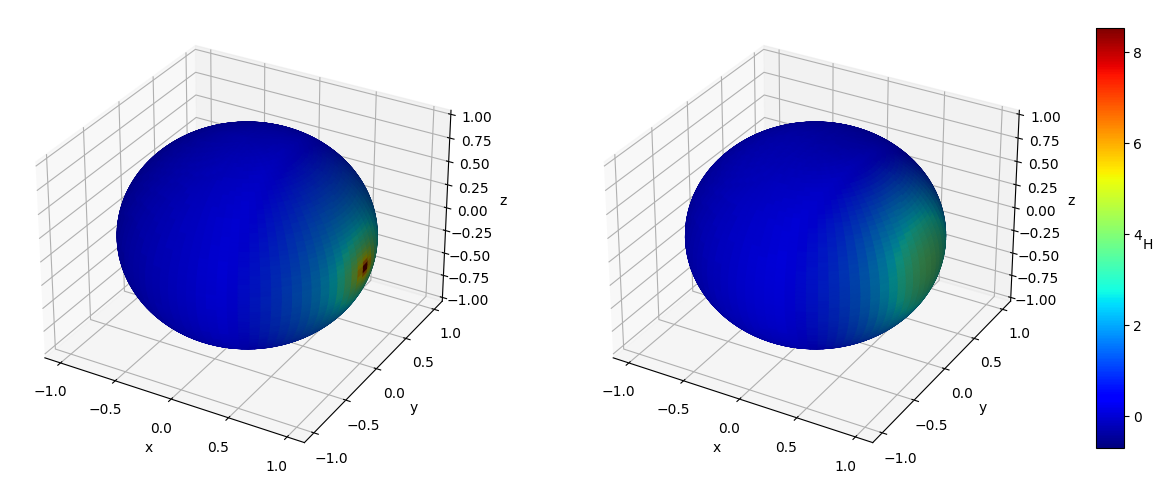

In [113]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

# Create the figure and the 3D axes

u = np.linspace(0, 2 * np.pi, 80)
v = np.linspace(0, np.pi, 80)

# Create the sphere surface
XX = 1 * np.outer(np.cos(u), np.sin(v))
YY = 1 * np.outer(np.sin(u), np.sin(v))
ZZ = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

# Create a random scalar field (unknown scale)

WW1 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW1[i][j] = Ham(torch.tensor([v[j],u[i],np.pi/2,0])).detach().numpy()
        
WW2 = XX.copy()
for j in range(len(XX[0])):
    for i in range(len(XX)):
        WW2[i][j] = prediction(torch.tensor([v[j],u[i],np.pi/2,0], dtype=torch.float32), rho).detach()


distance = np.mean((WW1-WW2))
WW2 = WW2+distance

# Get the min and max of the data for dynamic scaling
# Find the combined min and max to create a common color scale
combined_min = min(WW1.min(), WW2.min())
combined_max = max(WW1.max(), WW2.max())

# Normalize with the combined min and max
norm = Normalize(vmin=combined_min, vmax=combined_max)

fig = plt.figure(figsize=(14, 6))

# Plot WW1 on the left subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW1)), rstride=1, cstride=1)
ax1.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax1.yaxis.set_major_locator(MaxNLocator(5)) 
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Plot WW2 on the right subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(XX, YY, ZZ, facecolors=plt.cm.jet(norm(WW2)), rstride=1, cstride=1)
ax2.xaxis.set_major_locator(MaxNLocator(5))  # 5 ticks max on x-axis
ax2.yaxis.set_major_locator(MaxNLocator(5)) 
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')


# Add color bar with precise positioning
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.jet), cax=cbar_ax)
cbar.set_label('H', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.savefig("GroundTruth_and_Learned_Typhoon_ColorPlot.png", bbox_inches='tight')
plt.show()
